The data is as follows, we can start by looking at the initial budburst stage (in Julian day) of Quercus robur (English oak) in London, influenced by several factors:
Julian Date: The Julian date of budburst, standardized across years to reflect the timing of budburst during the early developmental stage.
Year: the calendar year in which each budburst was recorded, accounting for annual variations in budburst timing.
Girth: stem circumference of the tree at 1.3 m height (in centimeters), serving as a proxy for tree age and size.
Air Temperature: air temperature (in degrees Celsius) measured at 9:01 am each year, which influences the thermal conditions for growth.
Rainfall: capturing the total hourly rainfall (in millimeters) for each year, which affects water availability and thus influences budburst timing.

There are other budburst stages, tree species, and factors to consider, but we can start with this real quick.


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, 
    OneHotEncoder, FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [29]:
data = pd.read_csv('quercus.robur_only.csv')
data.head()

,Julian_Date,Year,Girth_cm,Grass_Temp..Deg.C...Smp.,Soil_Temp_4in...Deg.C...Smp.,Air_Temp..Deg.C...Smp.,Grass_Temp_Min..Deg.C...Min.,Grass_Temp_Max..Deg.C...Max.,Rain_mm_Tot...mm...Tot.,species,Air_Temp_Max...Deg.C...Max.
0,98,2015,89,16.8,8.23,12.45,0.354,29.93,0.0,quercus.robur,17.33
1,98,2015,155,16.8,8.23,12.45,0.354,29.93,0.0,quercus.robur,17.33
2,98,2015,174,16.8,8.23,12.45,0.354,29.93,0.0,quercus.robur,17.33
3,98,2015,91,16.8,8.23,12.45,0.354,29.93,0.0,quercus.robur,17.33
4,98,2015,61,16.8,8.23,12.45,0.354,29.93,0.0,quercus.robur,17.33


In [30]:
data.shape

(2344, 11)

#### Checking for duplicates

In [31]:
data.duplicated().sum()

np.int64(365)

In [19]:
365/2348

0.15545144804088587

In [32]:
data = data.drop_duplicates()
data = data.drop(columns=['Year','species'])

In [33]:
data.duplicated().sum()

np.int64(0)

In [34]:
# Separating features and target variable
X = data.drop(columns=['Julian_Date'])
y = data['Julian_Date']

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shapes of the resulting splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1583, 8), (396, 8), (1583,), (396,))

In [35]:
#Checking data types in training set
X_train.dtypes

Girth_cm                          int64
Grass_Temp..Deg.C...Smp.        float64
Soil_Temp_4in...Deg.C...Smp.    float64
Air_Temp..Deg.C...Smp.          float64
Grass_Temp_Min..Deg.C...Min.    float64
Grass_Temp_Max..Deg.C...Max.    float64
Rain_mm_Tot...mm...Tot.         float64
Air_Temp_Max...Deg.C...Max.     float64
dtype: object

In [36]:
#Summary statistics of training set
X_train.describe()

,Girth_cm,Grass_Temp..Deg.C...Smp.,Soil_Temp_4in...Deg.C...Smp.,Air_Temp..Deg.C...Smp.,Grass_Temp_Min..Deg.C...Min.,Grass_Temp_Max..Deg.C...Max.,Rain_mm_Tot...mm...Tot.,Air_Temp_Max...Deg.C...Max.
count,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000
mean,124.614024,14.677450,9.344781,10.761203,3.897736,24.001661,0.370057,15.586930
std,79.476730,3.929691,1.323674,3.146587,4.342025,6.231869,1.486433,3.262033
min,8.000000,6.334000,6.372000,3.985000,-89.500000,-61.650000,0.000000,8.310000
25%,70.000000,11.800000,8.500000,8.380000,0.145000,18.600000,0.000000,13.470000
50%,106.000000,14.190000,9.180000,10.540000,4.443000,25.530000,0.000000,14.890000
75%,155.000000,16.330000,10.240000,12.850000,7.098000,29.230000,0.000000,16.930000
max,592.000000,25.360000,16.140000,19.740000,11.570000,37.320000,27.000000,28.560000


array([[<Axes: title={'center': 'Girth_cm'}>,
        <Axes: title={'center': 'Grass_Temp..Deg.C...Smp.'}>,
        <Axes: title={'center': 'Soil_Temp_4in...Deg.C...Smp.'}>],
       [<Axes: title={'center': 'Air_Temp..Deg.C...Smp.'}>,
        <Axes: title={'center': 'Grass_Temp_Min..Deg.C...Min.'}>,
        <Axes: title={'center': 'Grass_Temp_Max..Deg.C...Max.'}>],
       [<Axes: title={'center': 'Rain_mm_Tot...mm...Tot.'}>,
        <Axes: title={'center': 'Air_Temp_Max...Deg.C...Max.'}>,
        <Axes: >]], dtype=object)

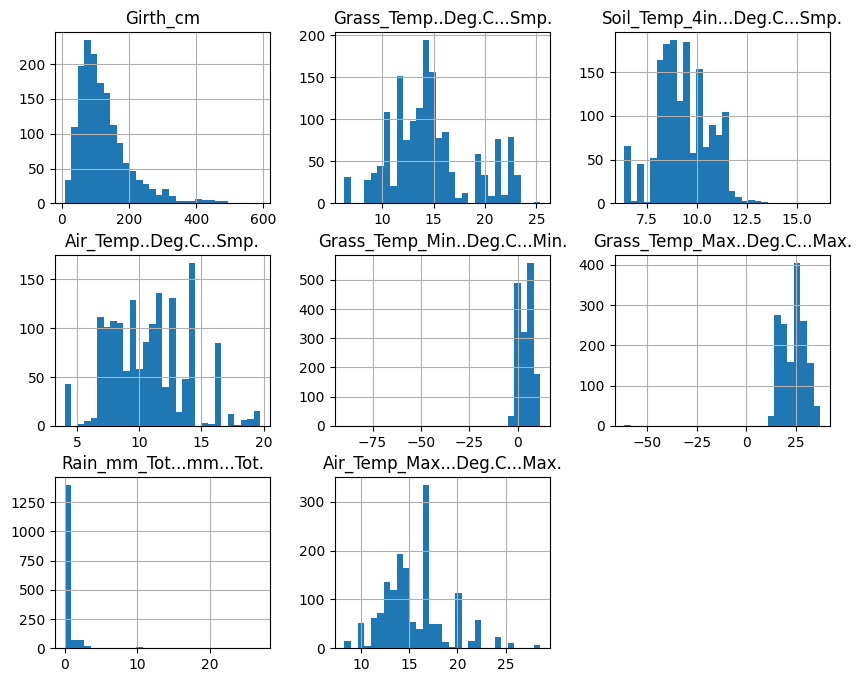

In [37]:
#Visualization of data distribution of numerical features in training set
X_train.hist(bins=30, figsize=(10,8))

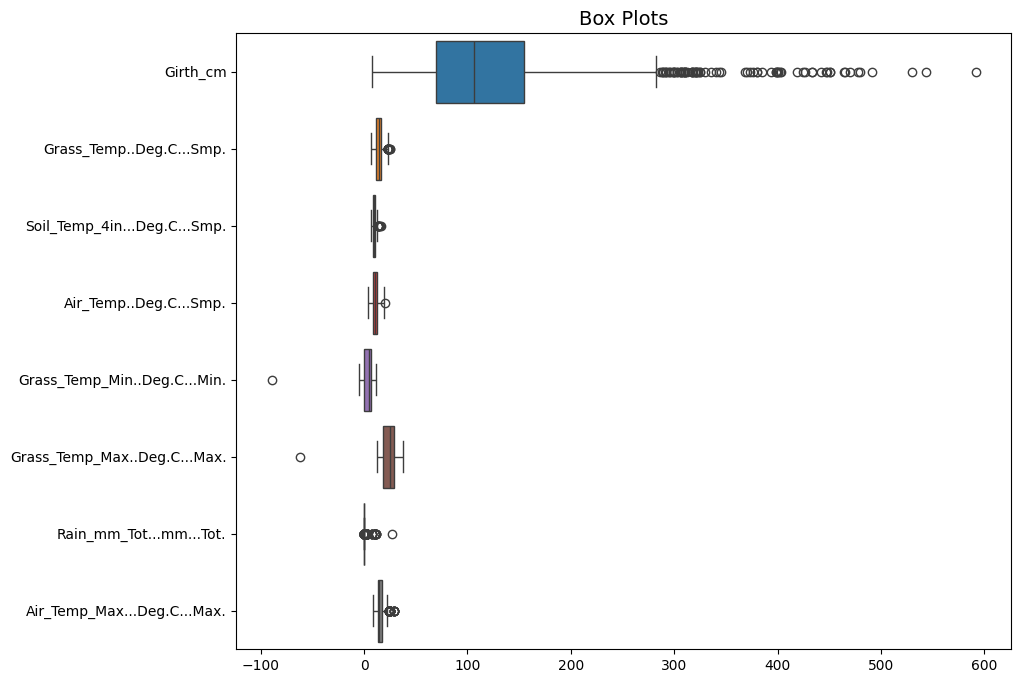

In [38]:
#  Box Plots to further visualize distribution
plt.figure(figsize=(10, 8))
sns.boxplot(data=X_train, orient='h')
plt.title('Box Plots', fontsize=14)
plt.show()

In [39]:
X_train.drop(columns=['Rain_mm_Tot...mm...Tot.'], inplace=True)

In [40]:
X_test.drop(columns=['Rain_mm_Tot...mm...Tot.'], inplace=True)

user input: When will the budburst occur if the temperature is 10 in June.
MONTH TEMPERATURE JULIAN YEAR
4       45          96